<a href="https://colab.research.google.com/github/sadrasa97/ANN-CNN-on-cifar-10/blob/main/Another_copy_of_Pile_heat_loss.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predicting chip pile dry matter loss using measured temperature greadients during the storage


## 0 Install and import modules and tools

In [ ]:
!pip install fipy
#!pip install 'gmsh==4.8.4'
!pip install gmsh
import numpy as np
from fipy import *
import datetime
import matplotlib.pylab as plt
from scipy.stats import norm
from scipy.special import erf
from scipy.spatial import distance_matrix
import pandas as pd
import statistics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 443.6/443.6 kB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.8/38.8 MB 23.4 MB/s eta 0:00:00


In [ ]:
!git clone https://github.com/salehahmadinia/wood_chip

Cloning into 'wood_chip'...
fatal: could not read Username for 'https://github.com': No such device or address


## 1 Using sensible heat flux to estimate dry matter loss from wood chip pile
***Background***

We know from observations that temperature in a wood chip pile remains higher than the surrounding environments. Temperature gradient between the pile interior and the surroundings onsets a flux of sensible heat. The flux is equal to:
\begin{equation}
Q_{sens} = k_{\tau} \nabla \tau \space\space\space\space   (1)
\end{equation}

where $Q_{sens}$ is the  sensible heat flux in $W m^{-2}$ across the pile surface, $k_{tau}$ is thermal conductivity of wood chip pile ($W m^{-1} K^{-1}$), and $\nabla \tau$ is temperature gradient ($K m^{-1}$). Temperature gradient can be obtained from the measured inside and outside temperatures, and thermal conductivity can be derived from porosity and chip moisture.

Throughout the measured 175 days, the pile temperature remained higher than the surroundings suggesting that the internal heat release dominates the enegry balance of the pile. Assuming that the organic matter decomposition in the pile dominates the heat source, the sensible heat flux at the pile exteriors would be caused by it, and the pile energy balance would be:

\begin{equation}
Q_{sens} = DM_{loss} \times H_{comb} - \Delta w \times H_v + \Delta \tau \times s_{chip} \space\space\space\space\space\space (2)
\end{equation}

where $DM_{loss}$ is the dry matter loss from the pile (kg), $H_{comb}$ is heat of combustion ($MJ kg^{-1}$), $\Delta w$ is the change in pile water content (kg), $H_v$ is the heat of vaporization of water (2.450 $MJ kg^{-1}$), $\Delta  \tau \times s_{chips}$ is the temperature change-caused difference in the heat content of the pile from the beginning and end of the experiment, $s_{chips}$ is the specific heat of the chips.

Combining equations (1) and (2), integrating the heat flux over the experiment time and arranging known and measured quantities to the right hand side of the equation, we get:
\begin{equation}
DM_{loss}   = \frac{\int_{0}^{end} k_{\tau} \nabla \tau + \Delta w \times H_v - \Delta \tau \times s_{chip} + k_{soil} \nabla \tau_{soil}}{H_{comb}} \space\space\space\space\space\space (3)
\end{equation}


***Heat loss to soil***

We estimate the heat loss from the pile to the soil beneath by using analytical solution of heat equation in a semi-infinite domain, maximum, minimum and mean pile temperatures. Depending on the magnitude, we take this into account in the calculations. Analytical solution for temperature ditribution in soil is given as:
\begin{equation}
\tau(z,t) = 1-erf(\frac{z}{2\sqrt{Dt}}) \space \space \space (4)
\end{equation}
Where $\tau(z,t)$ is temperature in soil in depth z and time t, erf is Gauss error function, and D is thermal diffusivity of soil. We calculate the heat flux Q from the pile to soil Using the temperature gradient and thermal conductivity at the lower bounadary of the pile.

Thermal diffusivity (D) of sandu soil varies between 0.4-0.8 $\times 10^{-6}$ m2 s-1.


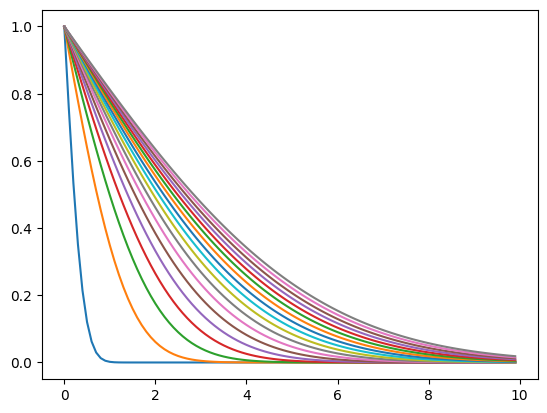

In [ ]:
from scipy.special import erf
D = 0.6*1e-6            #thermal diffusivity m2 s-1
depth = np.arange(0,10,0.1)
days = np.arange(1,175,10)
for d in days:
  t = 86400*d
  tdist = 1-erf(depth/(2*np.sqrt(D*t)))
  plt.plot(depth, tdist)



```
# This is formatted as code
```

## 1.1b 2D transient state solution


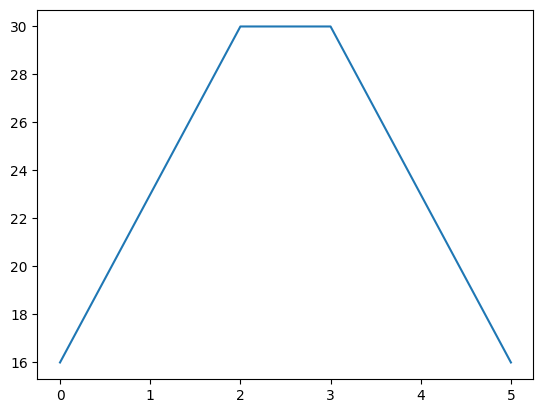

In [ ]:
from scipy.interpolate import interp1d
y = np.arange(0, 5.1, 0.1)
tbound = 16
tin = 30
tinter = interp1d(np.array([0, 2.0, 3.0, 5.0]), np.array([tbound, tin,tin,tbound]))
tsurface = tinter(y)
plt.plot(y,tsurface)




## 2 Functions

### 2.1 Thermo-physical properties: Thermal conductivity, specific heat

In [ ]:
import numpy as np

#---------------thermal conductivity [W m-1K-1]
cpar = {
    'water':[5.68781330e-01, 1.88568584e-03,-7.67385378e-06],
    'air':[2.41328087e-05,7.94739429e-08,-3.54285719e-11],
    'vapor':[3.75647536e-02,8.71540000e-05,2.00000000e-08],
    'wood':[0.14,0.0,0.0]
    }

#---------specific heat [kJ kg-1K-1]
cppar = {
    'water':[4.20783435e+00,-1.28615509e-03,1.41540541e-05],
    'air':[1.00376455e+00,3.08605877e-05,3.54285566e-07],
    'vapor':[1.85859549e+00,1.69782799e-04,1.37142912e-06],
    'wood':[1.76, 0.0,0.0]
    }


def thermal_conductivity(t, moist, poro,  chippar):                                                    # thermal conductivity W/(mK)
    """
    Input
        t temperature in deg C
    Output
        thermal conductuvity in W m-1 K-1
    """
    chippar['water']=moist #water(t, moistwb, poro, chippar)
    xv = lambda xi: chippar[xi]
    parallel_k =sum([xv(xi)*(cpar[xi][0]+cpar[xi][1]*t+cpar[xi][2]*np.power(t,2)) for xi in cpar.keys()])         # thermal conductivity of material, parallel computation

    perpendicular_k =sum([xv(xi)/(cpar[xi][0]+cpar[xi][1]*t+cpar[xi][2]*np.power(t,2)) for xi in cpar.keys()])    # thermal conductivity of material, parallel computation
    perpendicular_k = 1./perpendicular_k
    #k = (parallel_k + perpendicular_k)/2.
    #k= perpendicular_k
    k=parallel_k
    return k

def specific_heat(t,moist, poro, chippar):
    """
    Input:
        t temperature in deg C
    Output:
        heat capacity in J kg-1 K-1
    """
    chippar['water']= moist        #water(t, moistwb, poro)                                          # heat capacity parameterst for kJ/(kgK)
    return  sum([chippar[xi]*(cppar[xi][0]+cppar[xi][1]*t+cppar[xi][2]*np.power(t,2)) for xi in cpar.keys()])*1000.    # heat capacity



### 2.2 Temperature map inside the pile

In [ ]:

from fipy import *
import numpy as np
# Temperature map fuction
from scipy.interpolate import griddata

def T_map(X,Y, xx, yy, t_out, t_up_left, t_up_right, t_bottom):
  known_Ts = np.empty(0)                                                        # Lazy coding I admit :)
  known_xs = np.empty(0)
  known_ys= np.empty(0)

  offset = 0.4
  radi_sq = 1.1 #0.8
  points = np.where(((np.square(X) + np.square(Y-offset))<radi_sq) & (Y>1) & (X<0) )    # set the first known area values

  len_p11 = len(np.ravel(points))
  known_xs = np.append(known_xs, X[points])
  known_ys = np.append(known_ys, Y[points])
  known_Ts = np.append(known_Ts, np.ones(len_p11)*t_up_left)

  points = np.where(((np.square(X) + np.square(Y-offset))<radi_sq) & (Y>1) & (X>0) )    # the second nown area

  len_p12 = len(np.ravel(points))
  known_xs = np.append(known_xs, X[points])
  known_ys = np.append(known_ys, Y[points])
  known_Ts = np.append(known_Ts, np.ones(len_p12)*t_up_right)

  points = np.where(((np.square(X) + np.square(Y-offset))<radi_sq) & (Y<1))             # the third known area

  len_p22 = len(np.ravel(points))
  known_xs = np.append(known_xs, X[points])
  known_ys = np.append(known_ys, Y[points])
  known_Ts = np.append(known_Ts, np.ones(len_p22)*t_bottom)

  #ef = (mesh.exteriorFaces & (yy > -0.1) & (xx > -2.49) & (xx < 2.49))           # we know the T at the exterior faces
  ef = (mesh.exteriorFaces & (yy > -0.1) & (xx > -3.49) & (xx < 3.49))
  pef = np.where(ef)
  len_pef = len(np.ravel(pef))
  known_xs = np.append(known_xs, xx[pef])
  known_ys = np.append(known_ys, yy[pef])
  known_Ts = np.append(known_Ts, np.ones(len_pef)*t_out)


  points = np.array([known_xs, known_ys]).T                                     # ATTN! the form of the known coordinates
  gr = griddata(points, known_Ts, (X,Y))                                        #   arguments go here: known coordinates, known values
                                                                                #   and finally the coordinates where we want the                                                                                 #    interpolation to be done as tuple (X,Y)
  return gr

def get_locations(X,Y):
  offset = 0.4
  radi_sq = 2.0
  points_upleft = np.where(((np.square(X) + np.square(Y-offset))<radi_sq) & (Y>1) & (X<0) )    # set the first known area values
  points_upright = np.where(((np.square(X) + np.square(Y-offset))<radi_sq) & (Y>1) & (X>0) )    # the second nown area
  points_down =  np.where(((np.square(X) + np.square(Y-offset))<radi_sq) & (Y<1))
  points_all = np.where((np.square(X) + np.square(Y-offset))<radi_sq)
  return points_upleft, points_upright, points_down, points_all

#-----  Function call  ----------------------
mesh = Gmsh2D('/content/wood_chip/triang.msh')
X,Y=mesh.cellCenters
t_prof = CellVariable(name="Distance",
                    mesh=mesh,
                    value=10.)
xx, yy = mesh.faceCenters
print (len(X))

t_out=10.
t_up_left = 20.
t_up_right = 20.
t_bottom = 20.

gr = T_map(X,Y, xx, yy, t_out, t_up_left, t_up_right, t_bottom)
t_prof.setValue(gr)

fs = 14
fig = plt.figure(num='temps', figsize=(5,3))
grid = plt.GridSpec(1, 3, wspace=1.0, hspace=0.15)

ax_temp = plt.subplot(grid[0,:])
tpc=ax_temp.tripcolor(X, Y, np.ravel(t_prof), alpha=0.4)# , vmin=t_out, vmax=50)
ax_temp.plot(-0.6,1.4, 'ro', markersize = 15, label='Thermocouples')
ax_temp.plot(0.6,1.4, 'ro', markersize = 15)
ax_temp.plot(0,0.65, 'ro', markersize = 15)
ax_temp.legend(bbox_to_anchor=(0.85, 1.25), fontsize = fs)

ax_temp.set_ylabel('Height m', fontsize=fs)
cb = fig.colorbar(tpc, ax = ax_temp)
cb.set_label(label='Temperature, $^{o}$C', size=fs)
cb.ax.tick_params(labelsize=fs)
ax_temp.set_ylabel('Height m',fontsize = fs)
ax_temp.tick_params(axis='both', which='major', labelsize=fs)





EOFError: ignored

## 3. Measured data

In [ ]:
#Parameters and files
h_vapor = 2.450     # heat of vaporization of water MJ/kg
#h_comb = 19.0       # heat of combustion (wood) MJ/kg
#poro, delta_w, delta_tau, rho_solid, bd
meas = {'p1':{'t_file': '/content/wood_chip/pile1_sect_3_all.xlsx', 'slic':'p1s2',
                'poro':1.0-253.0/435.0, 'delta_w': 5.08/100, 'h_comb':19.31, 'moist': 0.33,
                'delta_tau':16.0-4.0, 'bd': 253, 'rho_s': 435, 'dmloss':3.71/100.0},
        'p2':{'t_file': '/content/wood_chip/pile2_sect_3_all.xlsx', 'slic':'p2s2',
                'poro':1.0-245.0/438.0, 'delta_w': 2.01/100, 'h_comb':19.56, 'moist': 0.33,
                'delta_tau':16.0-2.0, 'bd': 245, 'rho_s': 438, 'dmloss':6.66/100.0},
        'p3':{'t_file': '/content/wood_chip/pile2_sect_3_all.xlsx', 'slic':'p3s2',
                'poro':1.0-256.0/441.0, 'delta_w': 2.01/100, 'h_comb':19.72, 'moist': 0.33,
                'delta_tau':16.0-9.0, 'bd': 256, 'rho_s': 441, 'dmloss':3.46/100.0},
        'p4':{'t_file': '/content/wood_chip/pile4_sect_3_all.xlsx', 'slic':'p4s2',
                'poro':1.0-248.0/429.0, 'delta_w': 6.01/100, 'h_comb':19.97, 'moist': 0.33,
                'delta_tau':16.0-9.0, 'bd': 248, 'rho_s': 429, 'dmloss':2.09/100.0},
        'p5':{'t_file': '/content/wood_chip/pile5_sect_3_all.xlsx', 'slic':'p5s2',
                'poro':1.0-245.0/437.0, 'delta_w': 0.0/100, 'h_comb':19.57, 'moist': 0.33,
                'delta_tau':16.0-2.0, 'bd': 245, 'rho_s': 437, 'dmloss':4.62/100.0},
        'p6':{'t_file': '/content/wood_chip/pile6_sect_3_all.xlsx', 'slic':'p6s2',
                'poro':1.0-240.0/436.0, 'delta_w': 0.3/100, 'h_comb':19.6, 'moist': 0.33,
                'delta_tau':16.0-2.0, 'bd': 240, 'rho_s': 436, 'dmloss':4.15/100.0},
        'p7':{'t_file': '/content/wood_chip/pile7_sect_3_all.xlsx', 'slic':'p7s2',
                'poro':1.0-253.0/430.0, 'delta_w': 8.4/100, 'h_comb':19.6, 'moist': 0.33,
                'delta_tau':16.0-2.5, 'bd': 253, 'rho_s': 430, 'dmloss':2.65/100.0},
        'p8':{'t_file': '/content/wood_chip/pile8_sect_3_all.xlsx', 'slic':'p8s2',
                'poro':1.0-266.0/451.0, 'delta_w': 2.19/100, 'h_comb':19.25, 'moist': 0.33,
                'delta_tau':16.0-2.5, 'bd': 266, 'rho_s': 451, 'dmloss':5.15/100.0},
        }


## 4 Simulation

[link text](https://)### 4.1 Temperature profile in soil under the pile

In [ ]:
from fipy import *
from scipy.interpolate import interp1d
piles = ['p1', 'p2', 'p3', 'p4', 'p5', 'p6', 'p7', 'p8']
pile = piles[1]
temperatures = pd.read_excel(meas[pile]['t_file'], usecols=[0, 1, 2, 3, 4, 5, 6],
                             names=['date','t_bottom', 't_up_left', 't_up_right', 't_out', 'rh_out', 'rain'], skiprows=0)

days,_ = np.shape(temperatures)

def surface_temp(t_bound, tin):
    y = np.arange(0, 5.0, 0.1)
    tinter = interp1d(np.array([0, 2.0, 3.0, 5.0]), np.array([t_bound, tin,tin,t_bound]))
    return tinter(y)

#-------------FiPy initialization------------------------
nx = 50
nz = 50
soil_temperatures = np.zeros((200, nx*nz))
soil_temperature_gradients = np.zeros((200, nx*nz))
dx = 0.1
dz = 0.1
mesh_soil = Grid2D(nx=nx,ny=nz, dx=dx, dy=dz)
V=mesh_soil.cellVolumes
uf = mesh_soil.facesUp           # mask of the exterior faces
ixuf = np.where(uf)                                # indices of the exterior faces
#soil_exterior_area = mesh._faceAreas.data[uf]
soil_exterior_area = nx*dx
dt = 86400.            # one day
steps = 175             # one month

soil_hloss = np.zeros(days, dtype=float)

#----------FiPy variables-------------------------------
phi = CellVariable(name="temperature degC",
                   mesh=mesh_soil,
                   value=8.0  )
soil_t_grad = CellVariable(name="temperature gradient in soil",
                           mesh = mesh_soil,
                           value = 0.0)
D = 0.6 * 1e-6    #thermal diffusivity m2 s-1
kt_soil = 0.25 #W/mK
t_boundary = Variable(value = surface_temp(10,30))
phi.constrain(t_boundary, mesh_soil.facesUp)

eqT = TransientTerm() == DiffusionTerm(coeff=D)

step = 0
for t_out, t_in  in zip(temperatures['t_out'],temperatures['t_bottom']):
    t_boundary.setValue(surface_temp(t_out, t_in))
    eqT.solve(var=phi, dt=dt)
    soil_temperatures[step, :] = phi.value
    soil_t_grad =  phi.faceGrad.divergence
    soil_temperature_gradients[step, :] = soil_t_grad
    Q_soil = soil_t_grad*kt_soil                                                  # W/m2   J/(s m2)
    Q_soil = Q_soil*86400.*1e-6                                            # MJ/(day m2)
    Qf_soil = Q_soil.faceValue

    heat_loss_soil = sum(Q_soil.faceValue[ixuf]* soil_exterior_area)               # MJ/day
    soil_hloss[step] = heat_loss_soil
    if step%20==0:
      #print (t_out, t_in)
      #print (t_boundary.value)
      print (step)
    step+=1

FileNotFoundError: ignored

In [ ]:
heat_soil = {'p1':-1243, 'p2':-1195, 'p3':-1195, 'p4':-1238, 'p5':-1165, 'p6': -1244, 'p7':-1183, 'p8':-1236}

In [ ]:
plt.plot(np.cumsum(soil_hloss))
sum(soil_hloss)

NameError: ignored

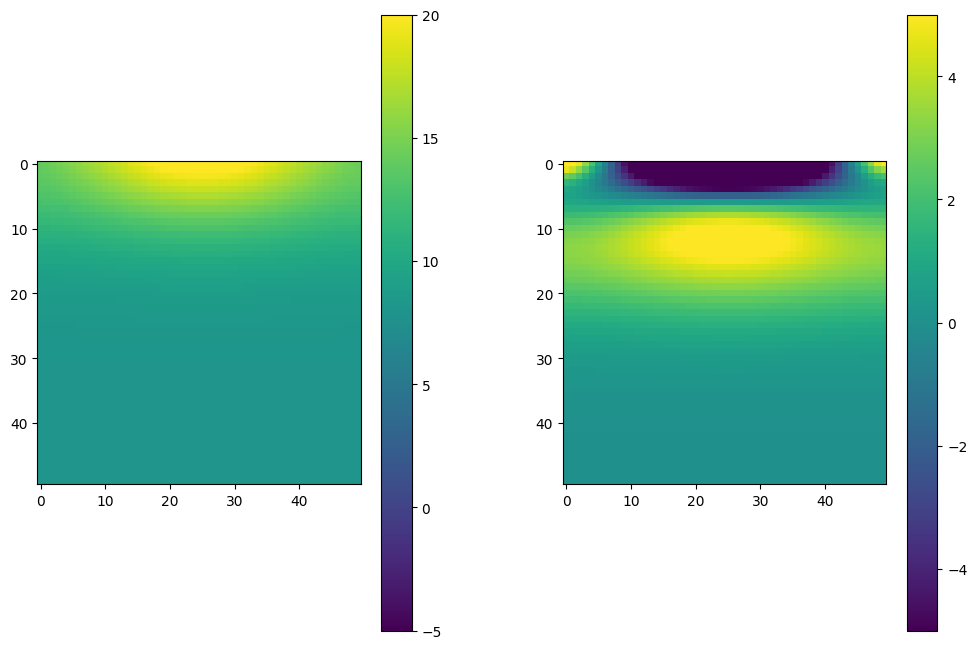

In [ ]:
import matplotlib.pylab as plt
import numpy as np

day = 11

fig = plt.figure(num='Tsoil', figsize=(12,8))
grid = plt.GridSpec(1, 2, wspace=0.3, hspace=0.3)

ax_T = plt.subplot(grid[0,0])
soilt = np.ravel(soil_temperatures[day,:])
soilt = np.reshape(soilt,(nz,nx))
soilt = np.flip(soilt,axis=0)
im0 = ax_T.imshow(soilt, vmin=-5, vmax=20)
fig.colorbar(im0, ax=ax_T)

ax_g = plt.subplot(grid[0,1])
soilg = np.ravel(soil_temperature_gradients[day,:])
soilg = np.reshape(soilg,(nz,nx))
soilg = np.flip(soilg,axis=0)
im1 = ax_g.imshow(soilg, vmin=-5, vmax=5)
fig.colorbar(im1, ax=ax_g)



In [ ]:

piles = ['p1', 'p2', 'p3', 'p4', 'p5', 'p6', 'p7', 'p8']
res ={}

for pile in piles:
  res[pile] ={}
  #pile = 'p1'
  slic = meas[pile]['slic']
  poro = meas[pile]['poro']
  chippar = {
      'water': meas[pile]['bd'] * meas[pile]['moist']/1000.,  # chip moisture to volumetric water content
      'air' :poro*(1.- 0.95),
      'vapor':poro*0.95,
      'wood':1.-poro,
      }

  temperatures = pd.read_excel(meas[pile]['t_file'], usecols=[0, 1, 2, 3, 4, 5, 6], names=['date','t_bottom', 't_up_left', 't_up_right', 't_out', 'rh_out', 'rain'], skiprows=0)
  days,_ = np.shape(temperatures)
  hloss = np.zeros(days, dtype=float)
  n=0
  mesh = Gmsh2D('/content/wood_chip/triang.msh')
  X,Y=mesh.cellCenters
  t_prof = CellVariable(name="Distance",
                    mesh=mesh,
                    value=10.)
  xx, yy = mesh.faceCenters
  print (len(X))

  xx, yy = mesh.faceCenters
  #ef = (mesh.exteriorFaces & (yy > 0.0) )           # mask of the exterior faces
  #ixef = np.where(ef)                               # indices of the exterior faces
  #exterior_area = mesh._faceAreas.data[ef]
  #exterior_area = np.sqrt(2.5**2 + 3**2) *2
  ef = (mesh.exteriorFaces & (yy > 0.0) )           # mask of the exterior faces
  ixef = np.where(ef)                                # indices of the exterior faces

  exterior_area = mesh._faceAreas.data[ef]
  #exterior_area = mesh._faceAreas[ef]
  #exterior_area = mesh._faceAreas[mesh.exteriorFaces.value]
  #print (ef, ixef, np.shape(exterior_area), np.sqrt(2.5**2 + 3**2)*2)

  for t_out, t_up_left, t_up_right, t_bottom, rh_out  in zip(temperatures['t_out'], temperatures['t_up_left'], temperatures['t_up_right'], \
                                                    temperatures['t_bottom'], temperatures['rh_out']):

        grT = T_map(X,Y, xx, yy, t_out, t_up_left, t_up_right, t_bottom)                 # temperature profile in pile in deg C
        t_prof.setValue(grT)
        poro = meas[pile]['poro']
        moist =  meas[pile]['bd'] * meas[pile]['moist']/1000.
        tforstd = [t_up_left, t_up_right, t_bottom]
        std_obs = statistics.stdev(tforstd)
        tgrad = t_prof.faceGrad.divergence                           # K/m
        k = thermal_conductivity(t_prof, moist, poro, chippar)                       # W/m/K
        Q = tgrad*k                                                  # W/m2   J/(s m2)
        Q = Q*86400.*1e-6                                            # MJ/(day m2)
        print (np.shape(Q.faceValue))
        print (np.shape(yy))
        print (max(Y), min(Y))

        heat_loss = sum(Q.faceValue[ixef]* exterior_area)               # MJ/day
        hloss[n] = heat_loss
        stdhloss = statistics.stdev(hloss)
        if n%20==0:
          print (pile, n)
        n+=1
  print (sum(hloss) + heat_soil[pile])
  t_ini = 16
  t_end = t_ini - meas[pile]['delta_tau']
  pilemass = sum(mesh.cellVolumes)*meas[pile]['bd']
  latent = h_vapor * meas[pile]['delta_w']*sum(mesh.cellVolumes)*meas[pile]['bd']
  poro  = meas[pile]['poro']
  moist =  meas[pile]['bd'] * meas[pile]['moist']/1000.
  delta = specific_heat(t_ini, moist, poro, chippar)*pilemass*meas[pile]['delta_tau']*1e-6

  dmloss_sim = (sum(hloss) - latent - delta + heat_soil[pile])/meas[pile]['h_comb']/pilemass*100
  std_sim = (stdhloss - latent - delta )/meas[pile]['h_comb']/pilemass*100
  res[pile]=[meas[pile]['dmloss']*100, dmloss_sim , std_obs, std_sim]
  print (res[pile])

1820
(2795,)
(2795,)
2.9500000000000006 0.021629004522739637
p1 0
(2795,)
(2795,)
2.9500000000000006 0.021629004522739637
(2795,)
(2795,)
2.9500000000000006 0.021629004522739637
(2795,)
(2795,)
2.9500000000000006 0.021629004522739637
(2795,)
(2795,)
2.9500000000000006 0.021629004522739637
(2795,)
(2795,)
2.9500000000000006 0.021629004522739637
(2795,)
(2795,)
2.9500000000000006 0.021629004522739637
(2795,)
(2795,)
2.9500000000000006 0.021629004522739637
(2795,)
(2795,)
2.9500000000000006 0.021629004522739637
(2795,)
(2795,)
2.9500000000000006 0.021629004522739637
(2795,)
(2795,)
2.9500000000000006 0.021629004522739637
(2795,)
(2795,)
2.9500000000000006 0.021629004522739637
(2795,)
(2795,)
2.9500000000000006 0.021629004522739637
(2795,)
(2795,)
2.9500000000000006 0.021629004522739637
(2795,)
(2795,)
2.9500000000000006 0.021629004522739637
(2795,)
(2795,)
2.9500000000000006 0.021629004522739637
(2795,)
(2795,)
2.9500000000000006 0.021629004522739637
(2795,)
(2795,)
2.9500000000000006 0.0

<ipython-input-15-e1d8ea654b4c>:22: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  a, _, _, _ = np.linalg.lstsq(obs, sim)


[0.84957433] 2.427


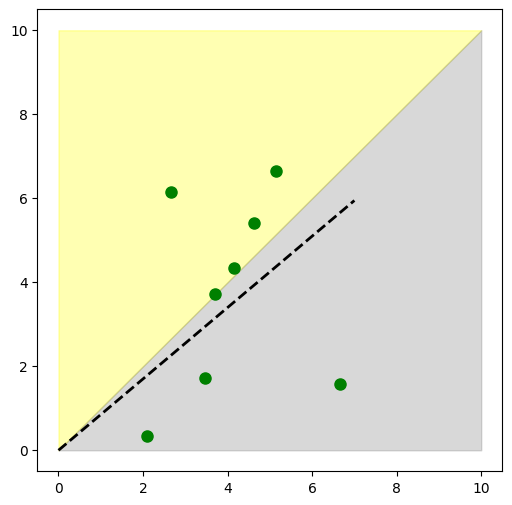

In [ ]:
fig = plt.figure(num='fit',figsize=(6,6))
col1 = 'yellow'
col2 = 'grey'
mval=10.
plt.fill_between([0., mval],[mval,mval],[0.,mval], color=col1, alpha=0.3)
plt.fill_between([0., mval],[0.,mval], [0.,0.], color=col2, alpha=0.3)

obs = []
sim = []
for k in res.keys():
  plt.plot(res[k][0],res[k][1], 'go', markersize=8)
  #plt.errorbar(res[k][0],res[k][1], xerr=res[k][3] , yerr=res[k][2], capsize=3)
  obs.append(res[k][0])
  sim.append(res[k][1])


sim=np.array(sim)
obs = np.array(obs)
rmse = np.round(np.sqrt(np.square(sim-obs).mean()),3)

obs = obs[:,np.newaxis]
a, _, _, _ = np.linalg.lstsq(obs, sim)
eq = 'y = ' +  str(np.round(a[0],3)) + 'x'
x =np.arange(0.0 , 8.0, 1)
plt.plot(x, a*x, 'k--', linewidth=2)
print (a, rmse)


In [ ]:
#T change
chippar = {
    'water': meas[pile]['bd'] * meas[pile]['moist']/1000.,  # chip moisture to volumetric water content
    'air' : poro*(1.- 0.95),
    'vapor':poro*0.95,
    'wood':1.-poro,
    }


t_ini = 16
t_end = t_ini - meas[pile]['delta_tau']
pilemass = sum(mesh.cellVolumes)*meas[pile]['bd']
latent = h_vapor * meas[pile]['delta_w']*sum(mesh.cellVolumes)*meas[pile]['bd']
poro  = meas[pile]['poro']
moist =  meas[pile]['bd'] * meas[pile]['moist']/1000.
delta = specific_heat(t_ini, moist, poro, chippar)*pilemass*meas[pile]['delta_tau']*1e-6

dmloss_sim = (sum(hloss) - latent - delta)/meas[pile]['h_comb']/pilemass*100
print (pile, ':', meas[pile]['dmloss']*100,',', dmloss_sim)

p8 : 5.15 , 9.866396917680918
